In [1]:
# Step 2: Import required libraries
from typing import Dict, Tuple, List, Optional
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
from rapidfuzz import fuzz
import math
from math import ceil
from prophet import Prophet
from datetime import datetime, timedelta, date

c:\Users\Sudhanshu Prabhat\Desktop\Minor Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
file_name = 'sales.xlsx'
df1 = pd.read_excel(file_name ,sheet_name=0)
df2 = pd.read_excel(file_name ,sheet_name=1)

In [3]:
required_fields = ["sku_id", "date", "sales_qty", "inventory", "price"]

In [4]:
field_synonyms = {
    "sku_id": ["sku", "sku_id", "item", "item_id", "product", "product_id", "code", "product_code","itemid"],
    "date": ["date", "invoice_date", "order_date", "txn_date", "trans_date"],
    "sales_qty": ["qty", "quantity", "quantity_sold", "units", "sales_units", "sales_qty","quantitysold"],
    "inventory": ["inventory", "stock", "stock_on_hand", "current_stock", "onhand", "available_stock","currentstock"],
    "price": ["price", "unit_price", "sales_price", "mrp", "selling_price","unitprice"],
}

In [5]:
# To normalize the headers : convert every header to a clean, machine-friendly snake_case form by lowercasing, stripping whitespace, replacing any run of non-alphanumeric characters with a single underscore, and trimming leading/trailing underscores
def normalize_name(name: str) -> str:
    name = re.sub(r'[^a-z0-9]+', '_', str(name).strip().lower()).strip('_')
    name = re.sub(r'_+', '_', name)
    return name

def normalize_headers(cols: List[str]) -> List[str]:
    return [normalize_name(c) for c in cols]

In [6]:
normal_headers1 = normalize_headers(df1.columns)

In [7]:
normal_headers2 = normalize_headers(df2.columns)

In [8]:
def score_header_for_field(header: str, field: str, synonyms: List[str]) -> int:
    # Compare header to the conceptual field name and its synonyms.
    s1 = fuzz.token_set_ratio(header, field)
    s2 = max((fuzz.token_set_ratio(header, syn) for syn in synonyms), default=0)
    score = max(s1, s2)

    # Small substring token bonus to break ties
    tokens = set(header.split('_'))
    syn_tokens = {t for syn in synonyms for t in syn.split('_')}
    if tokens & syn_tokens:
        score = min(100, score + 5)
    return int(score)

In [9]:
def map_required_fields(
    original_columns: List[str],
    threshold_required: int = 80
) -> Dict[str, str]:
    """
    Returns a single best original column for each required conceptual field.
    Ignores optional fields entirely. Raises ValueError if any required field
    cannot be confidently mapped (score < threshold_required).
    """
    # Build normalization maps
    norm_by_orig: Dict[str, str] = {orig: normalize_name(orig) for orig in original_columns}
    orig_by_norm: Dict[str, str] = {v: k for k, v in norm_by_orig.items()}
    norm_headers: List[str] = list(orig_by_norm.keys())

    # Build (field, header_norm, score) triples
    triples: List[Tuple[str, str, int]] = []
    for field in required_fields:
        field_norm = normalize_name(field)
        syns = [normalize_name(s) for s in field_synonyms.get(field, [field])]
        for h in norm_headers:
            sc = score_header_for_field(h, field_norm, syns)
            triples.append((field, h, sc))

    # Greedy assignment by descending score
    triples.sort(key=lambda x: x[2], reverse=True)

    chosen_hdrs: set = set()
    best_map: Dict[str, str] = {}
    best_scores: Dict[str, int] = {f: -1 for f in required_fields}

    for field, hdr_norm, sc in triples:
        if field in best_map:
            continue
        if hdr_norm in chosen_hdrs:
            continue
        best_map[field] = orig_by_norm[hdr_norm]
        best_scores[field] = sc
        chosen_hdrs.add(hdr_norm)

        # Early exit if all required fields assigned
        if len(best_map) == len(required_fields):
            break

    # Verify all required fields and thresholds
    missing = [f for f in required_fields if f not in best_map]
    if missing:
        raise ValueError(f"Auto-mapping failed: missing required matches for {missing}")

    weak = {f: s for f, s in best_scores.items() if s < threshold_required}
    if weak:
        raise ValueError(
            "Auto-mapping low confidence: " +
            ", ".join(f"{f} (score={s})" for f, s in weak.items())
        )

    return best_map

# Example usage:
if __name__ == "__main__":
    cols = ["ItemID", "Date", "QuantitySold", "CurrentStock", "UnitPrice", "StoreName"]
    mapping = map_required_fields(cols)

In [10]:
def invert_mapping(mapping:dict):
  d = {}
  for k,v in mapping.items():
    d[v] = k
    mapping = d
  return mapping
mapping = invert_mapping(mapping)

In [11]:
df1_original = df1.copy()
df2_original = df2.copy()

In [12]:
df1 = df1.rename(columns=mapping)
df2 = df2.rename(columns=mapping)

In [13]:
df1.columns = [re.sub(r"[^A-Za-z0-9_]+", "_", str(c)).strip("_") for c in df1.columns]
df2.columns = [re.sub(r"[^A-Za-z0-9_]+", "_", str(c)).strip("_") for c in df2.columns]

In [14]:
def missing_data(input_data):
    # This function returns dataframe with information about the percentage of nulls in each column and the column data type.

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

In [15]:
missing_values_1 = missing_data(df1)
missing_values_2 = missing_data(df2)

In [16]:
def fix_date(df_inp:pd.DataFrame) -> tuple[pd.DataFrame, dict]:
  logs = {"dropped_invalid_date_sales": 0, "deduped": 0, "neg_sales_dropped": 0, "neg_price_dropped": 0}

  df = df_inp.copy()
  df["date"] = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)
  for c in ["sales_qty", "inventory", "price"]:
    if c in df.columns:
      df[c] = pd.to_numeric(df[c], errors="coerce")

  # Sort for stable operations
  before = len(df)
  df = df.dropna(subset=["date", "sales_qty"])
  logs["dropped_invalid_date_sales"] = before - len(df)

  df = df[df["sales_qty"] >= 0]
  df = df.sort_values(["sku_id", "date"])
  return df , logs

In [17]:
df1, log1 = fix_date(df1)
df2, log2 = fix_date(df2)

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\1715621617.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date"] = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)
C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\1715621617.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["date"] = pd.to_datetime(df["date"], errors="coerce", infer_datetime_format=True)


In [18]:
def aggregate_sales_daily(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()

  df["date"] = pd.to_datetime(df["date"], errors="coerce")
  df["sales_qty"] = pd.to_numeric(df["sales_qty"], errors="coerce")
  if "price" in df.columns:
    df["price"] = pd.to_numeric(df["price"], errors="coerce")

  df = df.dropna(subset=["date", "sales_qty"])
  df = df[df["sales_qty"] >= 0]

  # Compute revenue where price is not NaN; rows with NaN price contribute 0 to revenue
  df["revenue"] = df["price"] * df["sales_qty"]

  # Sum qty and revenue per day, then compute price = revenue/qty where qty>0
  grouped = (
      df.groupby(["sku_id", "date"], as_index=False)
      .agg(sales_qty=("sales_qty", "sum"),
           revenue=("revenue", "sum"),
           price_nonnull=("price", lambda s: s.notna().any()))
    )
  grouped["price"] = np.where(
      (grouped["sales_qty"] > 0) & grouped["price_nonnull"],
      grouped["revenue"] / grouped["sales_qty"],
      np.nan
    )

  grouped = grouped.drop(columns=["revenue", "price_nonnull"])
  return grouped.sort_values(["sku_id","date"]).reset_index(drop=True)

In [19]:
df1 = aggregate_sales_daily(df1)

In [20]:
def clean_sales_df(df: pd.DataFrame , logs: dict) -> tuple[pd.DataFrame, dict]:
    df = df.copy()

    df = df.sort_values(["sku_id", "date"])

    # Drop rows with missing date or sales
    before = len(df)
    df = df.dropna(subset=["date", "sales_qty"])
    logs["dropped_invalid_date_sales"] = before - len(df)

    # Remove negative sales
    before = len(df)
    df = df[df["sales_qty"] >= 0]
    logs["neg_sales_dropped"] = before - len(df)

    # Remove negative prices (keep NaN)
    before = len(df)
    df = df[df["price"].isna() | (df["price"] >= 0)]
    logs["neg_price_dropped"] = before - len(df)

    # Forward-fill inventory within SKU
    if "inventory" in df.columns:
        df["inventory"] = df.groupby("sku_id", group_keys=False)["inventory"].apply(lambda s: s.ffill())

    # Deduplicate (sku_id, date)
    before = len(df)
    df = df.drop_duplicates(subset=["sku_id", "date"], keep="first")
    logs["deduped"] = before - len(df)

    return df, logs

In [21]:
df1_clean, logs1 = clean_sales_df(df1, log1)

In [22]:
def clean_inventory_df(
    df_inv: pd.DataFrame,
    ffill_limit: int = 30,
    sales_daily: pd.DataFrame | None = None  # expects ['sku_id','date','sales_qty'] if provided
) -> pd.DataFrame:
    df = df_inv.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["inventory"] = pd.to_numeric(df["inventory"], errors="coerce")
    df = df.dropna(subset=["date"])

    # Remove or cap negatives
    df.loc[df["inventory"] < 0, "inventory"] = 0

    # Resolve multiple records per day: keep last non-null of day
    df = (
        df.sort_values(["sku_id","date"])
          .groupby(["sku_id","date"], as_index=False)
          .agg(inventory=("inventory", lambda s: s.dropna().iloc[-1] if s.dropna().size else np.nan))
    )

    # Upsample to daily and forward-fill within limit
    out = []
    for sku, g in df.groupby("sku_id"):
        g = g.set_index("date").sort_index()
        idx = pd.date_range(g.index.min(), g.index.max(), freq="D")
        s = g["inventory"].reindex(idx).ffill(limit=ffill_limit)
        out.append(pd.DataFrame({"sku_id": sku, "date": s.index, "inventory": s.values}))
    inv_daily = pd.concat(out, ignore_index=True).sort_values(["sku_id","date"]).reset_index(drop=True)

    # Optionally join sales to include sales_qty in the output
    if sales_daily is not None and not sales_daily.empty:
        sales = sales_daily[["sku_id","date","sales_qty"]].copy()
        sales["date"] = pd.to_datetime(sales["date"], errors="coerce")
        inv_daily = inv_daily.merge(sales, on=["sku_id","date"], how="left")

    return inv_daily

In [23]:
df2_clean = clean_inventory_df(df2)

In [24]:
# Outer join to preserve all days
combined = (
    df1_clean.merge(df2_clean, on=["sku_id","date"], how="outer", validate="one_to_one")
       .sort_values(["sku_id","date"])
       .reset_index(drop=True)
)

# Optional: treat missing daily sales as 0, keep inventory NaN if unknown
# combined["sales_qty"] = combined["sales_qty"].fillna(0).astype(float)
# If price missing on days with no sales, keep as NaN; you may forward-fill per SKU if appropriate

In [25]:
# Create price_model aligned row-by-row
combined["price_model"] = (combined.sort_values(["sku_id","date"])
                           .groupby("sku_id", group_keys=False)["price"]
                           .transform(lambda s: s.ffill(limit=7).bfill(limit=1)))

# Keep canonical price NaN; price_model is for modeling only
# No extra overwrite needed for zero-sales rows

In [26]:
def make_features(combined: pd.DataFrame) -> pd.DataFrame:
    df = combined.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values(["sku_id","date"]).reset_index(drop=True)

    # Temporal
    df["dow"] = df["date"].dt.weekday
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    df["month"] = df["date"].dt.month
    df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
    df["is_month_end"] = df["date"].dt.is_month_end.astype(int)

    # Sales numeric
    df["sales_qty"] = pd.to_numeric(df["sales_qty"], errors="coerce").fillna(0.0)

    def add_grp_feats(g: pd.DataFrame) -> pd.DataFrame:
        s = g["sales_qty"]

        # Lags
        g["lag_1"] = s.shift(1)
        g["lag_7"] = s.shift(7)
        g["lag_14"] = s.shift(14)
        g["lag_28"] = s.shift(28)

        # Rolling windows
        g["roll7_mean"] = s.rolling(7).mean()
        g["roll14_mean"] = s.rolling(14).mean()
        g["roll28_mean"] = s.rolling(28).mean()
        g["roll7_std"] = s.rolling(7).std()
        g["roll28_std"] = s.rolling(28).std()

        # Price features (optional)
        if "price_model" in g.columns:
            pm = g["price_model"]
            g["price_pc"] = pm.pct_change()
            g["promo_flag"] = (pm < pm.rolling(28, min_periods=7).median() * 0.95).astype(int)
        else:
            g["price_pc"] = np.nan
            g["promo_flag"] = 0

        # Inventory features (optional)
        if "inventory" in g.columns:
            g["roll7_demand"] = s.rolling(7).sum()
            g["days_of_cover"] = np.where(
                g["roll7_demand"] > 0, g["inventory"] / (g["roll7_demand"] / 7.0), np.nan
            )
            g["stockout_flag"] = (g["inventory"] <= 0).astype(int)
        else:
            g["days_of_cover"] = np.nan
            g["stockout_flag"] = 0

        return g

    df = df.groupby("sku_id", group_keys=False).apply(add_grp_feats)

    # Drop rows before we have 28 days of history per SKU
    first_date = df.groupby("sku_id")["date"].transform("min")
    df_feat = df[df["date"] >= (first_date + pd.Timedelta(days=28))].copy()

    return df_feat.sort_values(["sku_id","date"]).reset_index(drop=True)

In [27]:
df_feat = make_features(combined)

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\2045720586.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  g["price_pc"] = pm.pct_change()
C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\2045720586.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  g["price_pc"] = pm.pct_change()
C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\2045720586.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

In [28]:
def choose_cadence(df_daily, min_nonzero_daily=30, zero_share_threshold=0.6):
    out = []
    for sku, g in df_daily.groupby('sku_id'):
        n = len(g)
        nonzero = (g['sales_qty'] > 0).sum()
        zero_share = 1 - nonzero / max(n,1)
        cadence = 'daily'
        if nonzero < min_nonzero_daily or zero_share > zero_share_threshold:
            cadence = 'weekly'
        out.append({'sku_id': sku, 'cadence': cadence, 'n': n, 'nonzero': nonzero, 'zero_share': zero_share})
    return pd.DataFrame(out)

In [29]:
cadence_df = choose_cadence(df_feat)
if (cadence_df['cadence'] == 'weekly').any():
  weekly_exists = True
else:
  weekly_exists = False

In [30]:
merged_data = df_feat.copy()
merged_data = merged_data.merge(cadence_df[['sku_id','cadence']], on='sku_id', how='left')

In [31]:
def run_minimal_eda(df):
    """
    Minimal EDA block that:
    - Generates summary tables
    - Creates core charts (sales over time, inventory, weekly seasonality, monthly seasonality)
    - Returns dict: {"figures": [...], "tables": {...}}

    df must contain: ['sku_id','date','sales_qty','inventory']
    """

    eda_outputs = {
        "figures": [],
        "tables": {}
    }

    # Ensure correct types
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values('date')

    # --------------------------------------------------------
    # 1. Data Summary
    # --------------------------------------------------------
    summary = pd.DataFrame({
        "total_rows": [len(df)],
        "unique_skus": [df['sku_id'].nunique()],
        "start_date": [df['date'].min()],
        "end_date": [df['date'].max()],
        "avg_sales_per_day": [df['sales_qty'].mean()],
    })
    eda_outputs["tables"]["summary"] = summary

    # --------------------------------------------------------
    # 2. Missing Value Summary
    # --------------------------------------------------------
    missing = df.isna().mean().round(3).to_frame("missing_frac")
    eda_outputs["tables"]["missing"] = missing

    # --------------------------------------------------------
    # 3. Sales Over Time (Total)
    # --------------------------------------------------------
    daily_sales = df.groupby('date')['sales_qty'].sum()
    fig1, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(daily_sales.index, daily_sales.values, lw=1)
    ax1.set_title("Total Sales Over Time")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Units Sold")
    ax1.grid(alpha=0.3)
    eda_outputs["figures"].append(("sales_over_time", fig1))

    # --------------------------------------------------------
    # 4. Inventory Over Time (Total)
    # --------------------------------------------------------
    if 'inventory' in df.columns:
        daily_inventory = df.groupby('date')['inventory'].sum()
        fig2, ax2 = plt.subplots(figsize=(10,4))
        ax2.plot(daily_inventory.index, daily_inventory.values, color='orange', lw=1)
        ax2.set_title("Total Inventory Over Time")
        ax2.set_xlabel("Date")
        ax2.set_ylabel("Units In Stock")
        ax2.grid(alpha=0.3)
        eda_outputs["figures"].append(("inventory_over_time", fig2))

    # --------------------------------------------------------
    # 5. Sales Distribution
    # --------------------------------------------------------
    fig3, ax3 = plt.subplots(figsize=(6,4))
    ax3.hist(df['sales_qty'], bins=40, color='steelblue', alpha=0.7)
    ax3.set_title("Sales Distribution (All SKUs)")
    ax3.set_xlabel("Daily Sales Qty")
    ax3.set_ylabel("Frequency")
    eda_outputs["figures"].append(("sales_distribution", fig3))

    # --------------------------------------------------------
    # 6. Weekly Seasonality
    # --------------------------------------------------------
    df['weekday'] = df['date'].dt.day_name()
    weekday_sales = df.groupby('weekday')['sales_qty'].mean().reindex(
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    )
    fig4, ax4 = plt.subplots(figsize=(7,4))
    ax4.bar(weekday_sales.index, weekday_sales.values, color='purple')
    ax4.set_title("Average Sales by Weekday")
    ax4.set_ylabel("Units Sold")
    ax4.set_xticklabels(weekday_sales.index, rotation=45)
    eda_outputs["figures"].append(("weekly_seasonality", fig4))

    # --------------------------------------------------------
    # 7. Monthly Seasonality
    # --------------------------------------------------------
    df['month'] = df['date'].dt.month_name()
    monthly_sales = df.groupby('month')['sales_qty'].mean().reindex(
        ['January','February','March','April','May','June','July','August','September','October','November','December']
    )
    fig5, ax5 = plt.subplots(figsize=(8,4))
    ax5.bar(monthly_sales.index, monthly_sales.values, color='green')
    ax5.set_title("Average Sales by Month")
    ax5.set_ylabel("Units Sold")
    ax5.set_xticklabels(monthly_sales.index, rotation=45)
    eda_outputs["figures"].append(("monthly_seasonality", fig5))

    # --------------------------------------------------------
    # 8. Top & Bottom 5 SKUs by Total Sales
    # --------------------------------------------------------
    sku_totals = df.groupby("sku_id")["sales_qty"].sum().sort_values(ascending=False)
    top5 = sku_totals.head(5).to_frame("total_sales")
    bottom5 = sku_totals.tail(5).to_frame("total_sales")

    eda_outputs["tables"]["top5_skus"] = top5
    eda_outputs["tables"]["bottom5_skus"] = bottom5

    # --------------------------------------------------------
    # Done
    # --------------------------------------------------------
    return eda_outputs

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\4101424320.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(weekday_sales.index, rotation=45)
C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\4101424320.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(monthly_sales.index, rotation=45)


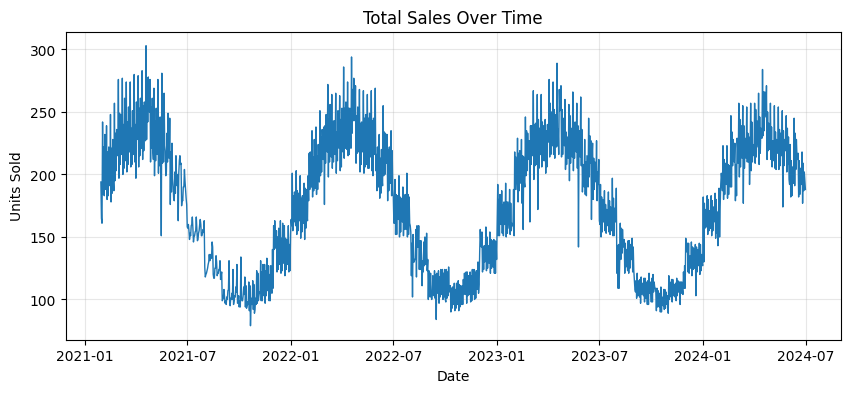

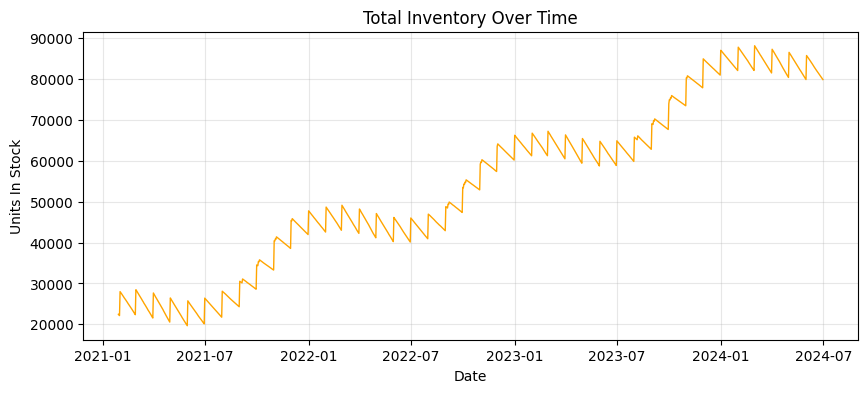

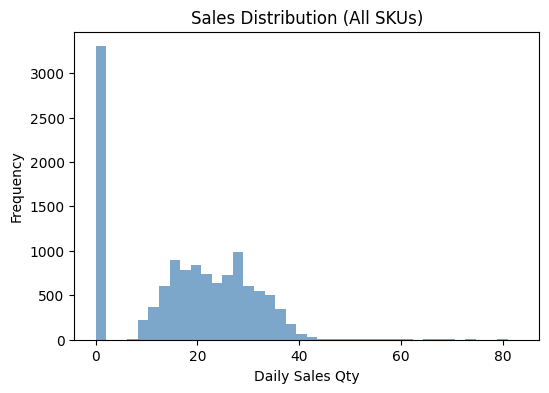

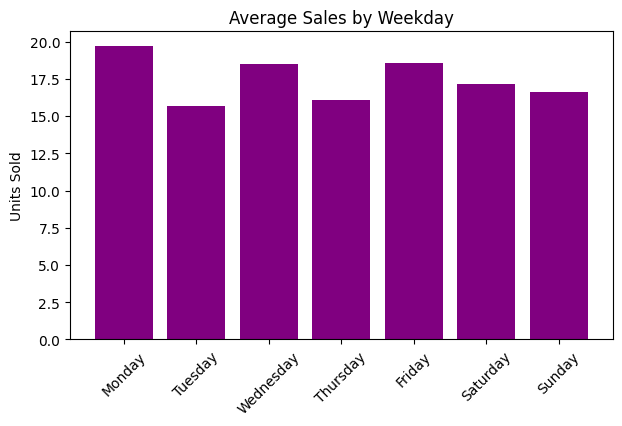

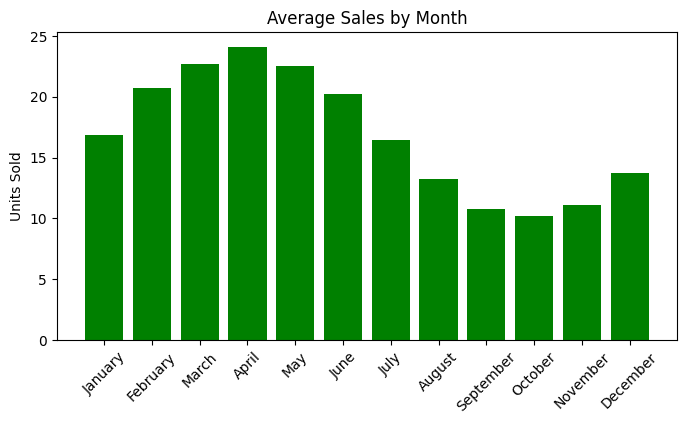

In [32]:
eda_results = run_minimal_eda(merged_data)

In [33]:
daily_SKU_data = merged_data[merged_data['cadence'] == 'daily'].copy()

In [34]:
def add_split_flag(df, horizon_days=28):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    out = []
    for sku, g in df.groupby('sku_id', sort=False):
        maxd = g['date'].max()
        cutoff = maxd - pd.Timedelta(days=horizon_days)
        g = g.assign(split_flag = g['date'].apply(lambda d: 'test' if d > cutoff else 'train'))
        out.append(g)
    return pd.concat(out, ignore_index=True)

In [35]:
daily_SKU_split = add_split_flag(daily_SKU_data)

In [36]:
def impute_for_prophet(df):
    g = df.sort_values(['sku_id','date']).copy()
    if 'price' in g.columns:
        g['price'] = g.groupby('sku_id')['price'].ffill().bfill().astype(float)
    if 'price_pc' in g.columns:
        g['price_pc'] = g['price_pc'].fillna(0.0).astype(float)
    for c in ['promo_flag','stockout_flag']:
        if c in g.columns:
            g[c] = g[c].fillna(0).astype(int)
    if 'days_of_cover' in g.columns:
        g['days_of_cover'] = g.groupby('sku_id')['days_of_cover'].ffill()
        g['days_of_cover'] = g['days_of_cover'].fillna(0.0).astype(float)
    return g

In [37]:
def prepare_target(df):
  g = df.copy()

  # If stockout occurs during training, mask the target
  if 'stockout_flag' in g.columns:
    mask = (g['split_flag'] == 'train') & (g['stockout_flag'] == 1)
    g.loc[mask, 'sales_qty'] = np.nan

  # Winsorize per-SKU
  def _winsor(x):
    q1, q99 = np.nanpercentile(x, 1), np.nanpercentile(x, 99)
    return np.clip(x, q1, q99)

  g['sales_qty'] = g.groupby('sku_id')['sales_qty'].transform(_winsor)
  g['y'] = np.log1p(g['sales_qty'].astype(float))

  return g

In [38]:
def run_prophet_daily(daily_SKU_split):
    # 1) Impute and target prep (use your existing functions)
    df = prepare_target(impute_for_prophet(daily_SKU_split)).copy()

    # 2) Force a clean 'ds' column inside the function
    if 'ds' in df.columns and 'date' in df.columns:
        # prefer the canonical 'date' column -> 'ds'
        df = df.drop(columns=['ds'])
    if 'date' not in df.columns:
        raise RuntimeError("Input is missing 'date' column")

    df = df.rename(columns={'date': 'ds'})
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
    if df['ds'].isna().any():
        bad = df[df['ds'].isna()][['sku_id', 'ds', 'split_flag']].head(5)
        raise RuntimeError(f"Unparseable dates in 'date' -> 'ds'. Sample rows:\n{bad}")

    # list of possible regressors (keeps your canonical names)
    regs = [c for c in ['price', 'promo_flag', 'stockout_flag', 'days_of_cover', 'price_pc'] if c in df.columns]

    # determine which inventory column to carry forward (if any)
    inventory_col = None
    if 'inventory' in df.columns:
        inventory_col = 'inventory'
    elif 'CurrentStock' in df.columns:
        inventory_col = 'CurrentStock'

    out = []

    # per-SKU loop (keeps original grouping order)
    for sku, g in df.groupby('sku_id', sort=False):
        g = g.sort_values('ds')

        # Build train/test: train must contain 'y' (log1p target); test keeps sales_qty for evaluation
        train_cols = ['ds', 'y'] + regs
        test_cols  = ['ds', 'sales_qty'] + regs
        if inventory_col:
            test_cols.append(inventory_col)

        train = g[g['split_flag'] == 'train'][train_cols].copy()
        test  = g[g['split_flag'] == 'test'][test_cols].copy()

        if train.empty or test.empty:
            # nothing to do for this SKU
            continue

        # If training y is all NaN (e.g., masked entirely), skip
        if train['y'].isna().all():
            print(f"[SKIP] {sku}: no valid training y");
            continue

        # Final guards for date NaT (shouldn't happen but safe)
        if train['ds'].isna().any() or test['ds'].isna().any():
            print(f"[SKIP] {sku}: NaT in ds");
            continue

        # Ensure numeric types for Prophet regressors and target
        train['y'] = train['y'].astype(float)
        for r in regs:
            if r in train.columns:
                train[r] = pd.to_numeric(train[r], errors='coerce').fillna(0.0)
            if r in test.columns:
                test[r]  = pd.to_numeric(test[r],  errors='coerce').fillna(0.0)

        # coerce inventory to numeric if present (keep NaNs if any)
        if inventory_col and inventory_col in test.columns:
            test[inventory_col] = pd.to_numeric(test[inventory_col], errors='coerce').fillna(0.0)

        # Prophet model (less flexible changepoint to reduce overfit)
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                    seasonality_mode='multiplicative', changepoint_prior_scale=0.05)
        for r in regs:
            m.add_regressor(r)

        # Fit and predict. Build predict columns robustly.
        fit_cols = ['ds', 'y'] + regs
        pred_cols = ['ds'] + regs if regs else ['ds']

        try:
            m.fit(train[fit_cols])
            fc = m.predict(test[pred_cols])
        except Exception as e:
            # If Prophet fails for this SKU, skip and warn
            print(f"[ERROR] {sku}: Prophet fit/predict failed: {e}")
            continue

        # ------------------------------
        # Back-transform fc from log1p -> original scale ONCE (do NOT double-expm1)
        # ------------------------------
        if 'yhat' in fc.columns:
            fc['yhat'] = np.expm1(fc['yhat'].clip(lower=np.log1p(0)))
        if 'yhat_lower' in fc.columns:
            fc['yhat_lower'] = np.expm1(fc['yhat_lower'].clip(lower=np.log1p(0)))
        if 'yhat_upper' in fc.columns:
            fc['yhat_upper'] = np.expm1(fc['yhat_upper'].clip(lower=np.log1p(0)))

        # Merge predicted yhat (original scale) with test rows
        # test already includes inventory_col (if present), so merged keeps it
        merged = test.copy().merge(fc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

        # add sku id and append
        merged['sku_id'] = sku
        out.append(merged)

    # return concatenated forecast frame or empty df
    return pd.concat(out, axis=0).reset_index(drop=True) if out else pd.DataFrame([])

In [39]:
def mape_array(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return np.nan

    # If many zeros present → switch to SMAPE
    if (y_true == 0).sum() / len(y_true) > 0.05:
        denom = (np.abs(y_true) + np.abs(y_pred)) / 2 + eps
        return np.mean(np.abs(y_pred - y_true) / denom) * 100

    # Standard robust MAPE
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_pred - y_true) / denom)) * 100

In [40]:
def mape(a_true, a_pred, eps=1e-6):
    """Robust MAPE/SMAPE hybrid for small or zero-valued series."""
    y_true = np.asarray(a_true).astype(float)
    y_pred = np.asarray(a_pred).astype(float)

    # mask invalid
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]
    if len(y_true) == 0:
        return np.nan

    zero_frac = np.sum(y_true == 0) / len(y_true)

    # If many zeros → use SMAPE
    if zero_frac > 0.05:
        denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + eps
        return float(np.mean(np.abs(y_pred - y_true) / denom) * 100.0)

    # Otherwise robust MAPE
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_pred - y_true) / denom)) * 100.0)


def mape_per_sku(fdf):
    return fdf.groupby('sku_id').apply(lambda g: mape(g['sales_qty'], g['yhat'])).reset_index(name='mape')

In [41]:
forecast_df_daily = run_prophet_daily(daily_SKU_split)

06:40:05 - cmdstanpy - INFO - Chain [1] start processing
06:40:05 - cmdstanpy - INFO - Chain [1] done processing
06:40:05 - cmdstanpy - INFO - Chain [1] start processing
06:40:05 - cmdstanpy - INFO - Chain [1] done processing
06:40:05 - cmdstanpy - INFO - Chain [1] start processing
06:40:06 - cmdstanpy - INFO - Chain [1] done processing
06:40:06 - cmdstanpy - INFO - Chain [1] start processing
06:40:06 - cmdstanpy - INFO - Chain [1] done processing
06:40:07 - cmdstanpy - INFO - Chain [1] start processing
06:40:07 - cmdstanpy - INFO - Chain [1] done processing
06:40:07 - cmdstanpy - INFO - Chain [1] start processing
06:40:07 - cmdstanpy - INFO - Chain [1] done processing
06:40:08 - cmdstanpy - INFO - Chain [1] start processing
06:40:08 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
sku_mape_daily = mape_per_sku(forecast_df_daily)

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\4099532191.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fdf.groupby('sku_id').apply(lambda g: mape(g['sales_qty'], g['yhat'])).reset_index(name='mape')


In [43]:
if weekly_exists:
    weekly_SKU_data = merged_data[merged_data['cadence'] == 'weekly'].copy()

In [44]:
def aggregate_weekly(df):
    """
    Takes DAILY rows for WEEKLY SKUs and returns a weekly-aggregated dataframe.
    Does NOT rename 'date' to 'ds' and does NOT create 'y'.
    run_prophet_weekly() will handle that.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # force each week to start on Monday
    df['week_start'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='D')

    # aggregation rules
    agg_dict = {
        'sales_qty': 'sum',
        'price': 'mean',
        'inventory': 'mean',
        'price_model': 'mean'
    }

    # add optional regressors if present
    for col in ['promo_flag', 'stockout_flag', 'days_of_cover', 'price_pc']:
        if col in df.columns:
            agg_dict[col] = 'mean'

    weekly = (
        df.groupby(['sku_id', 'week_start'], as_index=False)
          .agg(agg_dict)
          .rename(columns={'week_start':'date'})   # keep name 'date'
    )

    return weekly

In [45]:
if weekly_exists:
    weekly_SKU_data = aggregate_weekly(weekly_SKU_data)

In [46]:
def split_by_weeks(weekly_df, test_weeks=12, min_train_weeks=4):
    """
    Chronological split per SKU: last `test_weeks` weeks -> 'test', rest -> 'train'.
    - weekly_df: DataFrame with columns at weekly grain. Must contain 'sku_id' and 'date'.
    - If a SKU has <= test_weeks + min_train_weeks weeks, we shorten test to keep at least min_train_weeks train rows.
    Returns: copy of weekly_df with a new column 'split_flag'.
    """
    df = weekly_df.copy()
    df['date'] = pd.to_datetime(df['date'])

    out = []
    for sku, g in df.groupby('sku_id', sort=False):
        g = g.sort_values('date').copy()
        n = len(g)
        # default desired test size
        desired_test = int(test_weeks)
        # ensure at least min_train_weeks remain for training if possible
        if n <= (desired_test + min_train_weeks):
            # reduce test size to keep min_train_weeks if possible
            desired_test = max(1, n - min_train_weeks)
        # if history is extremely short, make last 1 week test
        desired_test = max(1, min(desired_test, n-1)) if n>1 else 0

        if desired_test == 0:
            g['split_flag'] = 'train'  # single-row history -> train
        else:
            cutoff_idx = n - desired_test
            g['split_flag'] = ['train'] * n
            for i in range(cutoff_idx, n):
                g.iloc[i, g.columns.get_loc('split_flag')] = 'test'
        out.append(g)
    return pd.concat(out, ignore_index=True)

In [47]:
if weekly_exists:
    weekly_SKU_split = split_by_weeks(weekly_SKU_data)

In [48]:
def run_weekly_prophet(weekly_SKU_split):
    """
    Per-SKU Prophet forecasting for weekly-cadence SKUs.
    - weekly_SKU_split: weekly-aggregated DataFrame (one row per sku/week) with 'date' and 'split_flag'.
    - The function internally calls impute_for_prophet(...) and prepare_target(...).
    - Returns a DataFrame with weekly test rows and columns: ['sku_id','ds','sales_qty','inventory','yhat','yhat_lower','yhat_upper', ...]
    """
    # 1) Impute and prepare target (keeps same pattern as daily pipeline)
    df = prepare_target(impute_for_prophet(weekly_SKU_split)).copy()

    # 2) Normalize 'date' -> 'ds' (Prophet expectation)
    if 'ds' in df.columns and 'date' in df.columns:
        df = df.drop(columns=['ds'])
    if 'date' not in df.columns:
        raise RuntimeError("Input is missing 'date' column (expected weekly 'date')")
    df = df.rename(columns={'date': 'ds'})
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
    if df['ds'].isna().any():
        bad = df[df['ds'].isna()][['sku_id','ds','split_flag']].head(5)
        raise RuntimeError(f"Unparseable dates in 'date' -> 'ds'. Sample rows:\n{bad}")

    # 3) Regressors (canonical list) — will use only those present
    regs = [c for c in ['price','promo_flag','stockout_flag','days_of_cover','price_pc'] if c in df.columns]

    # Determine inventory column to carry forward if present
    inventory_col = None
    if 'inventory' in df.columns:
        inventory_col = 'inventory'
    elif 'CurrentStock' in df.columns:
        inventory_col = 'CurrentStock'

    out = []

    # 4) Per-SKU loop
    for sku, g in df.groupby('sku_id', sort=False):
        g = g.sort_values('ds')

        # Build train/test: train uses 'y' (log1p target), test keeps 'sales_qty' for evaluation
        train_cols = ['ds','y'] + regs
        test_cols  = ['ds','sales_qty'] + regs
        if inventory_col:
            test_cols.append(inventory_col)

        train = g[g['split_flag']=='train'][train_cols].copy()
        test  = g[g['split_flag']=='test' ][test_cols].copy()

        if train.empty or test.empty:
            # nothing to model for this SKU at weekly grain
            continue

        # If training y is all NaN (e.g., fully masked) skip
        if train['y'].isna().all():
            print(f"[SKIP] {sku}: no valid training y")
            continue

        # Date guard
        if train['ds'].isna().any() or test['ds'].isna().any():
            print(f"[SKIP] {sku}: NaT in ds")
            continue

        # Ensure numeric regressors and target
        train['y'] = train['y'].astype(float)
        for r in regs:
            if r in train.columns:
                train[r] = pd.to_numeric(train[r], errors='coerce').fillna(0.0)
            if r in test.columns:
                test[r]  = pd.to_numeric(test[r],  errors='coerce').fillna(0.0)

        # Coerce inventory to numeric in test if present
        if inventory_col and inventory_col in test.columns:
            test[inventory_col] = pd.to_numeric(test[inventory_col], errors='coerce').fillna(0.0)

        # Prophet configured for weekly series (disable weekly/daily seasonality)
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                    seasonality_mode='multiplicative', changepoint_prior_scale=0.05)
        for r in regs:
            m.add_regressor(r)

        fit_cols = ['ds','y'] + regs
        pred_cols = ['ds'] + regs if regs else ['ds']

        try:
            m.fit(train[fit_cols])
            fc = m.predict(test[pred_cols])
        except Exception as e:
            print(f"[ERROR] {sku}: Prophet fit/predict failed: {e}")
            continue

        # Back-transform fc from log1p -> original scale (do this ONCE)
        if 'yhat' in fc.columns:
            fc['yhat'] = np.expm1(fc['yhat'].clip(lower=np.log1p(0)))
        if 'yhat_lower' in fc.columns:
            fc['yhat_lower'] = np.expm1(fc['yhat_lower'].clip(lower=np.log1p(0)))
        if 'yhat_upper' in fc.columns:
            fc['yhat_upper'] = np.expm1(fc['yhat_upper'].clip(lower=np.log1p(0)))

        # Merge and append (test contains sales_qty and inventory for evaluation)
        merged = test.copy().merge(fc[['ds','yhat','yhat_lower','yhat_upper']], on='ds', how='left')
        merged['sku_id'] = sku
        out.append(merged)

    # concat results
    return pd.concat(out, axis=0).reset_index(drop=True) if out else pd.DataFrame([])

In [49]:
if weekly_exists:
    forecast_df_weekly = run_weekly_prophet(weekly_SKU_split)

06:40:08 - cmdstanpy - INFO - Chain [1] start processing
06:40:08 - cmdstanpy - INFO - Chain [1] done processing
06:40:08 - cmdstanpy - INFO - Chain [1] start processing
06:40:08 - cmdstanpy - INFO - Chain [1] done processing
06:40:09 - cmdstanpy - INFO - Chain [1] start processing
06:40:09 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
if weekly_exists:
    sku_mape_weekly = mape_per_sku(forecast_df_weekly)

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\4099532191.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fdf.groupby('sku_id').apply(lambda g: mape(g['sales_qty'], g['yhat'])).reset_index(name='mape')


In [51]:
if weekly_exists:
    forecast_all = pd.concat([forecast_df_daily, forecast_df_weekly], ignore_index=True)
else:
    forecast_all = forecast_df_daily.copy()

In [52]:
sku_mape_all = mape_per_sku(forecast_all)

C:\Users\Sudhanshu Prabhat\AppData\Local\Temp\ipykernel_19756\4099532191.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return fdf.groupby('sku_id').apply(lambda g: mape(g['sales_qty'], g['yhat'])).reset_index(name='mape')


In [53]:
from math import ceil
def adjust_inventory_by_forecast_minimal(forecast_df, inv_df):
    """
    Minimal inventory adjustment (no optional params).
    Inputs:
      - forecast_df: DataFrame with columns ['sku_id','ds','yhat']
      - inv_df: DataFrame with columns ['sku_id','date','inventory']
    Returns:
      - inv_adj: adjusted inventory DataFrame (copy of inv_df with updated 'inventory' values)
      - sku_targets: DataFrame with per-sku avg_daily_forecast, median_period_days, target_days, target_stock
      - report_df: simple report of updates (sku_id, avg_daily_forecast, target_days, target_stock, updated, note)
    """
    # 1) validate columns
    for c in ['sku_id','ds','yhat']:
        if c not in forecast_df.columns:
            raise ValueError(f"forecast_df must contain column '{c}'")
    for c in ['sku_id','date','inventory']:
        if c not in inv_df.columns:
            raise ValueError(f"inv_df must contain column '{c}'")

    # fixed policy
    FAST_FRAC = 0.20
    SLOW_FRAC = 0.20
    FAST_DAYS = 14
    MEDIUM_DAYS = 30
    SLOW_DAYS = 60
    MIN_DAYS = 7

    # shallow copies
    fc = forecast_df[['sku_id','ds','yhat']].copy()
    inv = inv_df.copy()

    # normalize types
    fc['ds'] = pd.to_datetime(fc['ds'])
    inv['date'] = pd.to_datetime(inv['date'])
    inv = inv.reset_index(drop=True)

    # 2) compute per-sku avg_daily_forecast and median period (to detect weekly/daily)
    rows = []
    for sku, g in fc.groupby('sku_id'):
        g = g.sort_values('ds')
        if len(g) == 0:
            continue
        if len(g) > 1:
            diffs = g['ds'].diff().dt.days.dropna()
            median_period = int(max(1, np.median(diffs)))
        else:
            median_period = 1
        avg_yhat = float(g['yhat'].mean())
        avg_daily = avg_yhat / median_period
        rows.append({'sku_id': sku, 'median_period_days': median_period,
                     'avg_yhat': avg_yhat, 'avg_daily_forecast': avg_daily})
    sku_stats = pd.DataFrame(rows).set_index('sku_id')

    if sku_stats.empty:
        raise ValueError("forecast_df contains no SKUs or no yhat values")

    # 3) determine quantile cutoffs and assign target days
    vals = sku_stats['avg_daily_forecast'].replace(0, np.nan).fillna(0.0)
    q_fast = vals.quantile(1.0 - FAST_FRAC)
    q_slow = vals.quantile(SLOW_FRAC)

    def choose_days(v):
        if v <= 0:
            return max(SLOW_DAYS, MIN_DAYS)
        if v >= q_fast:
            return max(FAST_DAYS, MIN_DAYS)
        if v <= q_slow:
            return max(SLOW_DAYS, MIN_DAYS)
        return max(MEDIUM_DAYS, MIN_DAYS)

    sku_stats['target_days'] = sku_stats['avg_daily_forecast'].apply(choose_days)

    # 4) compute target stock
    sku_stats['target_stock'] = sku_stats.apply(
        lambda r: int(ceil(max(0.0, r['avg_daily_forecast'] * float(r['target_days'])))), axis=1
    )

    # 5) apply to inventory: clip historical values, set latest snapshot to target
    inv_adj = inv.copy()
    report_rows = []
    for sku, r in sku_stats.reset_index().iterrows():
        sku_id = r['sku_id']
        target_stock = int(r['target_stock'])
        target_days = int(r['target_days'])
        avg_daily = float(r['avg_daily_forecast'])

        mask = inv_adj['sku_id'] == sku_id
        if not mask.any():
            report_rows.append({
                'sku_id': sku_id,
                'avg_daily_forecast': avg_daily,
                'target_days': target_days,
                'target_stock': target_stock,
                'updated': False,
                'note': 'no inventory rows'
            })
            continue

        # clip historical inventory to not exceed target
        try:
            inv_adj.loc[mask, 'inventory'] = inv_adj.loc[mask, 'inventory'].clip(upper=target_stock)
        except Exception:
            inv_adj.loc[mask, 'inventory'] = inv_adj.loc[mask, 'inventory'].apply(
                lambda v: min(v, target_stock) if pd.notna(v) else target_stock
            )

        # set latest snapshot to target
        latest_idx = inv_adj[mask].sort_values('date').tail(1).index
        updated_flag = False
        if len(latest_idx) > 0:
            inv_adj.loc[latest_idx, 'inventory'] = target_stock
            updated_flag = True

        report_rows.append({
            'sku_id': sku_id,
            'avg_daily_forecast': avg_daily,
            'target_days': target_days,
            'target_stock': target_stock,
            'updated': updated_flag,
            'note': ''
        })

    report_df = pd.DataFrame(report_rows)
    sku_targets = sku_stats.reset_index()

    return inv_adj, sku_targets, report_df

In [54]:
inv_df = merged_data[['sku_id','date','inventory']].copy()
inv_df
inv_adjusted, sku_targets, report_df = adjust_inventory_by_forecast_minimal(
    forecast_all,
    inv_df
)

In [55]:
inv_map = dict(zip(inv_adjusted['sku_id'], inv_adjusted['inventory']))
forecast_all['inventory'] = forecast_all['sku_id'].map(inv_map)

In [56]:
def generate_inventory_recommendations(forecast_df, merged_data):
    """
    Generates SKU-level inventory recommendations.

    Assumptions:
      - forecast_df contains per-sku forecast rows (test/future) and ideally has an 'inventory' column.
        Required columns: ['sku_id','ds','yhat','sales_qty' (if available)]
      - merged_data is the full historical merged dataset and contains inventory snapshots (columns: ['sku_id','date','inventory'])
        This is used only as a fallback when forecast_df does not include inventory.

    Returns:
      recommendations_df with columns:
        ['sku_id','ds','inventory','forecast_demand','days_cover','recommendation']
    """

    # constants / thresholds (keep as your previous defaults; tweak if needed)
    EPS = 1e-6
    REORDER_DAYS = 7        # recommend reorder if days_of_cover < REORDER_DAYS
    SOON_DAYS = 3           # "soon" stockout if < SOON_DAYS
    OVERSTOCK_DAYS = 45     # overstock threshold

    # defensive checks
    if 'sku_id' not in forecast_df.columns or 'ds' not in forecast_df.columns or 'yhat' not in forecast_df.columns:
        raise ValueError("forecast_df must contain ['sku_id','ds','yhat']")

    # Prepare fallback inventory map from merged_data: latest snapshot per sku
    inv_map = {}
    if 'inventory' in merged_data.columns and 'date' in merged_data.columns:
        latest = (merged_data.sort_values(['sku_id','date'])
                          .groupby('sku_id', sort=False)
                          .tail(1)[['sku_id','inventory']])
        inv_map = dict(zip(latest['sku_id'], latest['inventory'].astype(float)))

    rec_rows = []

    # iterate per-sku (we assume forecast_df can be large; groupby is fine)
    for sku, g in forecast_df.groupby('sku_id', sort=False):
        g = g.sort_values('ds').copy()

        # prefer inventory in forecast_df if present (per-row inventory)
        has_inventory_col = 'inventory' in g.columns

        # if forecast_df doesn't have inventory, fall back to inv_map value (same for all rows of sku)
        fallback_inventory = inv_map.get(sku, np.nan)

        # compute avg/rolling forecasts if needed (we'll compute per-row recommendation)
        for _, row in g.iterrows():
            inv_val = None
            if has_inventory_col:
                inv_val = row['inventory']
            else:
                inv_val = fallback_inventory

            # coerce numeric and safe guard
            try:
                inv_val = float(inv_val) if pd.notna(inv_val) else np.nan
            except Exception:
                inv_val = np.nan

            yhat = float(row['yhat']) if not pd.isna(row['yhat']) else 0.0
            ds = row['ds']

            # days of cover relative to forecast (forward-looking)
            days_cover = inv_val / (yhat + EPS) if pd.notna(inv_val) else np.nan

            status = []
            # stockout today
            if pd.notna(inv_val) and inv_val <= 0:
                status.append("STOCKOUT: no inventory")

            # risk levels
            if pd.notna(days_cover):
                if days_cover < 1:
                    status.append("High stockout risk: covers <1 day")
                elif days_cover < SOON_DAYS:
                    status.append(f"Potential stockout soon (<{SOON_DAYS} days)")
            else:
                status.append("No inventory data")

            # reorder suggestion
            if pd.notna(days_cover) and days_cover < REORDER_DAYS:
                status.append("Reorder recommended")

            # overstock
            if pd.notna(days_cover) and days_cover > OVERSTOCK_DAYS:
                status.append(f"Overstock: >{OVERSTOCK_DAYS} days of cover")

            # slow mover heuristic (use historical avg from merged_data if available)
            slow_flag = False
            if 'sales_qty' in merged_data.columns:
                # historical avg daily for sku
                hist_avg = merged_data.loc[merged_data['sku_id']==sku,'sales_qty'].mean()
                if not np.isnan(hist_avg) and hist_avg < 3:
                    slow_flag = True
            if slow_flag:
                status.append("Slow mover: low historical demand")

            rec_msg = "; ".join(status) if status else "Healthy"

            rec_rows.append({
                'sku_id': sku,
                'ds': ds,
                'inventory': inv_val,
                'forecast_demand': yhat,
                'days_cover': round(days_cover, 2) if pd.notna(days_cover) else np.nan,
                'recommendation': rec_msg
            })

    rec_df = pd.DataFrame(rec_rows)
    # keep column order tidy
    cols = ['sku_id','ds','inventory','forecast_demand','days_cover','recommendation']
    return rec_df[cols]


In [57]:
recommendations_df = generate_inventory_recommendations(forecast_all, merged_data)

In [58]:
def make_cover_figure(title="Sales & Inventory Forecast Report", subtitle=None, toc=None):
    fig = plt.figure(figsize=(11,8.5))
    fig.clf()
    ax = fig.add_subplot(1,1,1); ax.axis('off')
    ax.text(0.5, 0.78, title, ha='center', va='center', fontsize=22, weight='bold')
    if subtitle is None:
        subtitle = f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ax.text(0.5, 0.72, subtitle, ha='center', va='center', fontsize=10)
    if toc:
        ax.text(0.06, 0.60, "Contents:", fontsize=12, weight='bold')
        for i,line in enumerate(toc):
            ax.text(0.08, 0.56 - i*0.04, line, fontsize=10)
    return fig

In [59]:
def make_total_sales_fig(merged_data):
    df = merged_data.copy(); df['date'] = pd.to_datetime(df['date'])
    daily_sales = df.groupby('date')['sales_qty'].sum()
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(daily_sales.index, daily_sales.values, lw=1)
    ax.set_title("Total Sales Over Time"); ax.set_ylabel("Units sold"); ax.grid(alpha=0.25)
    return fig

In [60]:
def make_weekday_fig(merged_data):
    df = merged_data.copy(); df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.day_name()
    weekday_sales = df.groupby('weekday')['sales_qty'].mean().reindex(
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(weekday_sales.index, weekday_sales.values); ax.set_title("Average Sales by Weekday"); ax.tick_params(axis='x', rotation=45)
    return fig

In [61]:
def make_mape_table_fig(sku_mape, rows_per_page=40):
    # returns list of figs (chunked)
    figs = []
    for start in range(0, len(sku_mape), rows_per_page):
        chunk = sku_mape.iloc[start:start+rows_per_page]
        fig, ax = plt.subplots(figsize=(11,8.5)); ax.axis('off')
        ax.set_title("MAPE per SKU (daily) — worst to best", fontsize=14)
        table_data = [["sku_id","mape (%)"]]
        for _, r in chunk.iterrows():
            table_data.append([r['sku_id'], f"{r['mape']:.2f}" if not np.isnan(r['mape']) else "nan"])
        table = ax.table(cellText=table_data, loc='center', cellLoc='left')
        table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1, 1.2)
        figs.append(fig)
    return figs

In [62]:
def make_sku_plot(sku, merged_data, forecast_df, sku_mape_df):
    hist = merged_data[merged_data['sku_id']==sku].sort_values('date')
    fc = forecast_df[forecast_df['sku_id']==sku].sort_values('ds')
    fig, ax = plt.subplots(figsize=(11,4))
    ax.plot(hist['date'], hist['sales_qty'], label='Actual', marker='o', lw=1, ms=3)
    ax.plot(fc['ds'], fc['yhat'], label='Predicted', marker='o', lw=1, ms=3, linestyle='--')
    if 'yhat_lower' in fc.columns and 'yhat_upper' in fc.columns:
        ax.fill_between(fc['ds'], fc['yhat_lower'], fc['yhat_upper'], alpha=0.25)
    mape_val = sku_mape_df.loc[sku_mape_df['sku_id']==sku,'mape']
    m = float(mape_val.values[0]) if mape_val.size>0 else np.nan
    ax.set_title(f"SKU: {sku}  —  MAPE: {m:.2f}%")
    ax.set_xlabel("Date"); ax.set_ylabel("Units sold"); ax.grid(alpha=0.2); ax.legend()
    return fig

In [63]:
def compute_inventory_health(recommendations_df, overstock_days=45, understock_days=7):
    """
    Returns: dict with counts and percents, and a per-sku status DataFrame (latest row per sku).
    Uses recommendations_df with columns ['sku_id','ds','inventory','forecast_demand','days_cover','recommendation'].
    """
    df = recommendations_df.copy()
    # get latest row per sku (by ds)
    latest = df.sort_values(['sku_id','ds']).groupby('sku_id', sort=False).tail(1).reset_index(drop=True)
    # classify by days_cover
    def classify_row(r):
        d = r.get('days_cover', np.nan)
        if pd.isna(d):
            return 'unknown'
        if d <= 0:
            return 'stockout'
        if d < understock_days:
            return 'understock'
        if d > overstock_days:
            return 'overstock'
        return 'healthy'
    latest['inv_status'] = latest.apply(classify_row, axis=1)
    counts = latest['inv_status'].value_counts().to_dict()
    total = len(latest)
    percents = {k: (v/total*100.0) for k,v in counts.items()}
    summary = {
        'counts': counts,
        'percents': percents,
        'total_skus': total
    }
    return summary, latest

In [64]:
def top_skus_by_sales(merged_data, top_n=10):
    """
    Returns DataFrame of top N skus by total historical sales, with total and avg daily.
    """
    md = merged_data.copy()
    md['date'] = pd.to_datetime(md['date'])
    agg = md.groupby('sku_id').agg(total_sales=('sales_qty','sum'),
                                   avg_daily=('sales_qty', lambda x: x.sum()/md['date'].nunique()))
    agg = agg.sort_values('total_sales', ascending=False).reset_index()
    return agg.head(top_n)

In [65]:
def sku_performance_table(merged_data, sku_mape_all, sku_targets, inv_latest):
    """
    Builds table with: sku_id, total_sales, avg_daily, mape, target_days, target_stock, inv_status, days_cover
    inv_latest: latest inventory snapshot or recommendations latest rows (must have sku_id, inventory, days_cover, inv_status)
    """
    # sales aggregates
    md = merged_data.copy(); md['date']=pd.to_datetime(md['date'])
    sales_agg = md.groupby('sku_id').agg(total_sales=('sales_qty','sum'),
                                         avg_daily=('sales_qty', lambda x: x.sum()/md['date'].nunique())).reset_index()
    mape = sku_mape_all.copy() if sku_mape_all is not None else pd.DataFrame(columns=['sku_id','mape'])
    targets = sku_targets.copy() if sku_targets is not None else pd.DataFrame(columns=['sku_id','target_stock','target_days'])
    inv = inv_latest[['sku_id','inventory','days_cover','inv_status']].copy() if 'inv_status' in inv_latest.columns else inv_latest[['sku_id','inventory']]
    # join
    df = sales_agg.merge(mape, on='sku_id', how='left').merge(targets[['sku_id','target_days','target_stock']], on='sku_id', how='left').merge(inv, on='sku_id', how='left')
    # fill NaNs
    df['mape'] = df['mape'].fillna(np.nan)
    df['target_days'] = df['target_days'].fillna(np.nan)
    df['target_stock'] = df['target_stock'].fillna(np.nan)
    df['days_cover'] = df.get('days_cover', np.nan)
    return df.sort_values('total_sales', ascending=False)

In [66]:
def make_pie_fig(labels, values, title=None):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.pie(values, labels=labels, autopct='%1.0f%%', startangle=90, pctdistance=0.8)
    ax.axis('equal')
    if title: ax.set_title(title)
    return fig

def make_bar_fig(x, y, xlabel=None, ylabel=None, title=None, rotation=45):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(x, y)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title: ax.set_title(title)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    return fig

In [67]:
def make_table_fig_from_df(df, title=None, max_rows=40, base_fontsize=10, figsize=(11,8.5)):
    disp = df.copy()
    nrows = len(disp)
    if nrows == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.axis('off')
        if title:
            fig.suptitle(title, fontsize=12, y=0.98)
        return fig

    pages = math.ceil(nrows / max_rows)
    figs = []

    for p in range(pages):
        start = p * max_rows
        end = min((p + 1) * max_rows, nrows)
        chunk = disp.iloc[start:end]

        fig, ax = plt.subplots(figsize=figsize)
        ax.axis('off')

        # Title outside axes to avoid overlap
        if title:
            page_suffix = f" — page {p+1}/{pages}" if pages > 1 else ""
            fig.suptitle(f"{title}{page_suffix}", fontsize=12, y=0.98)

        # Reserve room under the suptitle
        plt.subplots_adjust(top=0.88)

        # Dynamic fontsize (reduce when many rows)
        rows_in_chunk = len(chunk)
        fontsize = max(6, base_fontsize - int(rows_in_chunk / 20))

        # Build table with header + rows
        rows_table = [list(chunk.columns)] + chunk.astype(str).values.tolist()
        table = ax.table(cellText=rows_table, loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(fontsize)

        # More vertical scaling for larger chunks
        vscale = 1.2 + (rows_in_chunk / max_rows) * 0.4
        table.scale(1, vscale)

        figs.append(fig)

    return figs if len(figs) > 1 else figs[0]

In [68]:
def build_pdf(
    path, merged_data, forecast_daily,
    sku_mape, sku_targets=None,
    recs=None, max_sku_plots=20
    ):
    """
    Build a multi-page PDF summarizing EDA, MAPE, inventory targets,
    recommendations, and per-SKU time series.
    """

    def make_header_page(text):
        """A simple header figure that never conflicts with tables."""
        fig, ax = plt.subplots(figsize=(11, 1.0))
        ax.axis("off")
        fig.suptitle(text, fontsize=16, y=0.6)
        return fig

    toc = [
        "1) EDA",
        "2) MAPE (daily)",
        "3) Inventory targets",
        "4) Recommendations",
        "5) Per-SKU time series"
    ]

    def _save_possible_multi(fig_or_list):
        if fig_or_list is None:
            return
        if isinstance(fig_or_list, list):
            for f in fig_or_list:
                pdf.savefig(f); plt.close(f)
        else:
            pdf.savefig(fig_or_list); plt.close(fig_or_list)

    with PdfPages(path) as pdf:

        # Cover
        _save_possible_multi(make_cover_figure(toc=toc))

        # --- EDA ---
        _save_possible_multi(make_total_sales_fig(merged_data))
        _save_possible_multi(make_weekday_fig(merged_data))

        # --- Top SKUs ---
        try:
            top_skus_df = top_skus_by_sales(merged_data, top_n=10)
            if not top_skus_df.empty:
                _save_possible_multi(make_bar_fig(
                    x=top_skus_df['sku_id'].astype(str),
                    y=top_skus_df['total_sales'],
                    xlabel="sku_id",
                    ylabel="Total sales",
                    title="Top 10 SKUs by total historical sales"
                ))

                _save_possible_multi(make_pie_fig(
                    labels=top_skus_df['sku_id'].astype(str).tolist(),
                    values=top_skus_df['total_sales'].tolist(),
                    title="Top 10 SKUs share of historical sales"
                ))
        except Exception as e:
            print("Warning:", e)

        # --- MAPE ---
        try:
            m_res = make_mape_table_fig(sku_mape)
            if isinstance(m_res, (list, tuple)):
                for f in m_res: _save_possible_multi(f)
            else:
                try:
                    for f in m_res: _save_possible_multi(f)
                except:
                    _save_possible_multi(m_res)
        except Exception as e:
            print("Warning:", e)

        # --- Inventory Targets ---
        if sku_targets is not None:

            # HEADER
            _save_possible_multi(make_header_page("Inventory Targets"))

            try:
                tbl = make_table_fig_from_df(
                    sku_targets, title=None, max_rows=60, base_fontsize=8
                )
                _save_possible_multi(tbl)
            except:
                pass

        # --- Recommendations ---
        if recs is not None and len(recs) > 0:

            # HEADER
            _save_possible_multi(make_header_page("Recommendations"))

            try:
                # full table
                tbl = make_table_fig_from_df(
                    recs, title=None, max_rows=60, base_fontsize=8
                )
                _save_possible_multi(tbl)

                # summary visuals
                if "recommendation" in recs.columns:
                    counts = recs["recommendation"].value_counts()
                    if len(counts) > 0:
                        _save_possible_multi(make_pie_fig(
                            counts.index.astype(str).tolist(),
                            counts.values.tolist(),
                            title="Recommendation Types"
                        ))

                if "sku_id" in recs.columns:
                    top_recs = recs["sku_id"].value_counts().head(10)
                    if len(top_recs) > 0:
                        _save_possible_multi(make_bar_fig(
                            top_recs.index.astype(str).tolist(),
                            top_recs.values.tolist(),
                            xlabel="sku_id",
                            ylabel="count",
                            title="Top Recommended SKUs"
                        ))
            except Exception as e:
                print("Warning:", e)

        # --- Per SKU ---
        plotted = 0
        try:
            for sku in forecast_daily['sku_id'].unique():
                if plotted >= max_sku_plots:
                    break
                fig = make_sku_plot(sku, merged_data, forecast_daily, sku_mape)
                _save_possible_multi(fig)
                plotted += 1
        except Exception as e:
            print("Warning:", e)

    print("PDF written:", path)


In [69]:
build_pdf(
    "summary_report.pdf",
    merged_data=merged_data,
    forecast_daily=forecast_all,
    sku_mape=sku_mape_all,
    sku_targets=sku_targets,
    recs=recommendations_df,
    max_sku_plots=25
)

PDF written: summary_report.pdf
